If you are just a student and dont have enough computation power and/or training set  
Just use a pre-trained model as we do  
Using pre-trained model from there: https://github.com/balancap/SSD-Tensorflow  

In [1]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import sys
this_dir = os.getcwd()
lib_path = os.path.join(this_dir, 'SSD-Tensorflow')
sys.path.append(lib_path)

from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
import visualization

In [4]:
isess = tf.InteractiveSession()

In [5]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = this_dir + '/data/SSD-VGG/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from /home/jovyan/work/NetsLab/data/SSD-VGG/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt


In [6]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


[1.1753053665161133, 1.1468868255615234, 1.135038137435913, 1.12050199508667, 1.1468641757965088, 1.1398212909698486, 1.1444661617279053, 1.1340718269348145, 1.1531295776367188, 1.1445322036743164, 1.1436090469360352, 1.1337907314300537, 1.1213030815124512, 1.13590669631958, 1.1377537250518799, 1.1367287635803223, 1.1416354179382324, 1.1752028465270996, 1.1562621593475342, 1.1363403797149658, 1.1388335227966309, 1.1304819583892822, 1.1276443004608154, 1.1350510120391846, 1.1303904056549072, 1.1364986896514893, 1.1390295028686523, 1.1577425003051758, 1.1451191902160645, 1.1346120834350586, 1.1396374702453613, 1.1430916786193848, 1.1393733024597168, 1.1327118873596191, 1.139190912246704, 1.1412043571472168, 1.165201187133789, 1.1410636901855469, 1.1380596160888672, 1.1460816860198975, 1.1466705799102783, 1.1497275829315186, 1.1359901428222656, 1.129117727279663, 1.144754409790039, 1.1451714038848877, 1.137277603149414, 1.1375970840454102, 1.1437811851501465, 1.1340758800506592, 1.1460461

  0%|          | 0/99 [00:00<?, ?it/s]

000000000139.jpg


  1%|          | 1/99 [00:01<01:56,  1.19s/it]

000000000285.jpg


  2%|▏         | 2/99 [00:02<01:54,  1.18s/it]

000000000632.jpg


  3%|▎         | 3/99 [00:03<01:52,  1.17s/it]

000000000724.jpg


  4%|▍         | 4/99 [00:04<01:50,  1.16s/it]

000000000776.jpg


  5%|▌         | 5/99 [00:05<01:49,  1.16s/it]

000000000785.jpg


  6%|▌         | 6/99 [00:06<01:48,  1.16s/it]

000000000802.jpg


  7%|▋         | 7/99 [00:08<01:46,  1.16s/it]

000000000872.jpg


  8%|▊         | 8/99 [00:09<01:45,  1.16s/it]

000000000885.jpg


  9%|▉         | 9/99 [00:10<01:44,  1.16s/it]

000000001000.jpg


 10%|█         | 10/99 [00:11<01:43,  1.16s/it]

000000001268.jpg


 11%|█         | 11/99 [00:12<01:42,  1.16s/it]

000000001296.jpg


 12%|█▏        | 12/99 [00:13<01:40,  1.16s/it]

000000001353.jpg


 13%|█▎        | 13/99 [00:15<01:39,  1.16s/it]

000000001425.jpg


 14%|█▍        | 14/99 [00:16<01:38,  1.16s/it]

000000001490.jpg


 15%|█▌        | 15/99 [00:17<01:37,  1.16s/it]

000000001503.jpg


 16%|█▌        | 16/99 [00:18<01:36,  1.16s/it]

000000001532.jpg


 17%|█▋        | 17/99 [00:19<01:34,  1.16s/it]

000000001584.jpg


 18%|█▊        | 18/99 [00:20<01:33,  1.16s/it]

000000001675.jpg


 19%|█▉        | 19/99 [00:21<01:32,  1.16s/it]

000000001761.jpg


 20%|██        | 20/99 [00:23<01:31,  1.16s/it]

000000001818.jpg


 21%|██        | 21/99 [00:24<01:30,  1.16s/it]

000000001993.jpg


 22%|██▏       | 22/99 [00:25<01:29,  1.16s/it]

000000002006.jpg


 23%|██▎       | 23/99 [00:26<01:27,  1.16s/it]

000000002149.jpg


 24%|██▍       | 24/99 [00:27<01:26,  1.16s/it]

000000002153.jpg


 25%|██▌       | 25/99 [00:28<01:25,  1.16s/it]

000000002157.jpg


 26%|██▋       | 26/99 [00:30<01:24,  1.16s/it]

000000002261.jpg


 27%|██▋       | 27/99 [00:31<01:23,  1.16s/it]

000000002299.jpg


 28%|██▊       | 28/99 [00:32<01:22,  1.16s/it]

000000002431.jpg


 29%|██▉       | 29/99 [00:33<01:20,  1.16s/it]

000000002473.jpg


 30%|███       | 30/99 [00:34<01:19,  1.16s/it]

000000002532.jpg


 31%|███▏      | 31/99 [00:35<01:18,  1.16s/it]

000000002587.jpg


 32%|███▏      | 32/99 [00:36<01:17,  1.16s/it]

000000002592.jpg


 33%|███▎      | 33/99 [00:38<01:16,  1.16s/it]

000000002685.jpg


 34%|███▍      | 34/99 [00:39<01:15,  1.16s/it]

000000002923.jpg


 35%|███▌      | 35/99 [00:40<01:13,  1.16s/it]

000000003156.jpg


 36%|███▋      | 36/99 [00:41<01:12,  1.16s/it]

000000003255.jpg


 37%|███▋      | 37/99 [00:42<01:11,  1.16s/it]

000000003501.jpg


 38%|███▊      | 38/99 [00:43<01:10,  1.16s/it]

000000003553.jpg


 39%|███▉      | 39/99 [00:45<01:09,  1.15s/it]

000000003661.jpg


 40%|████      | 40/99 [00:46<01:08,  1.15s/it]

000000003845.jpg


 41%|████▏     | 41/99 [00:47<01:06,  1.15s/it]

000000003934.jpg


 42%|████▏     | 42/99 [00:48<01:05,  1.15s/it]

000000004134.jpg


 43%|████▎     | 43/99 [00:49<01:04,  1.15s/it]

000000004395.jpg


 44%|████▍     | 44/99 [00:50<01:03,  1.15s/it]

000000004495.jpg


 45%|████▌     | 45/99 [00:51<01:02,  1.15s/it]

000000004765.jpg


 46%|████▋     | 46/99 [00:53<01:01,  1.15s/it]

000000004795.jpg


 47%|████▋     | 47/99 [00:54<00:59,  1.15s/it]

000000005001.jpg


 48%|████▊     | 48/99 [00:55<00:58,  1.15s/it]

000000005037.jpg


 49%|████▉     | 49/99 [00:56<00:57,  1.15s/it]

000000005060.jpg


 51%|█████     | 50/99 [00:57<00:56,  1.15s/it]

000000005193.jpg


 52%|█████▏    | 51/99 [00:58<00:55,  1.15s/it]

000000005477.jpg


 53%|█████▎    | 52/99 [00:59<00:54,  1.15s/it]

000000005503.jpg


 54%|█████▎    | 53/99 [01:01<00:53,  1.15s/it]

000000005529.jpg


 55%|█████▍    | 54/99 [01:02<00:51,  1.15s/it]

000000005586.jpg


 56%|█████▌    | 55/99 [01:03<00:50,  1.15s/it]

000000005600.jpg


 57%|█████▋    | 56/99 [01:04<00:49,  1.15s/it]

000000005992.jpg


 58%|█████▊    | 57/99 [01:05<00:48,  1.15s/it]

000000006012.jpg


 59%|█████▊    | 58/99 [01:06<00:47,  1.15s/it]

000000006040.jpg


 60%|█████▉    | 59/99 [01:08<00:46,  1.15s/it]

000000006213.jpg


 61%|██████    | 60/99 [01:09<00:44,  1.15s/it]

000000006460.jpg


 62%|██████▏   | 61/99 [01:10<00:43,  1.15s/it]

000000006471.jpg


 63%|██████▎   | 62/99 [01:11<00:42,  1.15s/it]

000000006614.jpg


 64%|██████▎   | 63/99 [01:12<00:41,  1.15s/it]

000000006723.jpg


 65%|██████▍   | 64/99 [01:13<00:40,  1.15s/it]

000000006763.jpg


 66%|██████▌   | 65/99 [01:14<00:39,  1.15s/it]

000000006771.jpg


 67%|██████▋   | 66/99 [01:16<00:38,  1.15s/it]

000000006818.jpg


 68%|██████▊   | 67/99 [01:17<00:36,  1.15s/it]

000000006894.jpg


 69%|██████▊   | 68/99 [01:18<00:35,  1.15s/it]

000000006954.jpg


 70%|██████▉   | 69/99 [01:19<00:34,  1.15s/it]

000000007088.jpg


 71%|███████   | 70/99 [01:20<00:33,  1.15s/it]

000000007108.jpg


 72%|███████▏  | 71/99 [01:21<00:32,  1.15s/it]

000000007278.jpg


 73%|███████▎  | 72/99 [01:23<00:31,  1.15s/it]

000000007281.jpg


 74%|███████▎  | 73/99 [01:24<00:29,  1.15s/it]

000000007386.jpg


 75%|███████▍  | 74/99 [01:25<00:28,  1.15s/it]

000000007511.jpg


 76%|███████▌  | 75/99 [01:26<00:27,  1.15s/it]

000000007574.jpg


 77%|███████▋  | 76/99 [01:27<00:26,  1.15s/it]

000000007784.jpg


 78%|███████▊  | 77/99 [01:28<00:25,  1.15s/it]

000000007795.jpg


 79%|███████▉  | 78/99 [01:29<00:24,  1.15s/it]

000000007816.jpg


 80%|███████▉  | 79/99 [01:31<00:23,  1.15s/it]

000000007818.jpg


 81%|████████  | 80/99 [01:32<00:21,  1.15s/it]

000000007977.jpg


 82%|████████▏ | 81/99 [01:33<00:20,  1.15s/it]

000000007991.jpg


 83%|████████▎ | 82/99 [01:34<00:19,  1.15s/it]

000000008021.jpg


 84%|████████▍ | 83/99 [01:35<00:18,  1.15s/it]

000000008211.jpg


 85%|████████▍ | 84/99 [01:36<00:17,  1.15s/it]

000000008277.jpg


 86%|████████▌ | 85/99 [01:38<00:16,  1.15s/it]

000000008532.jpg


 87%|████████▋ | 86/99 [01:39<00:15,  1.16s/it]

000000008629.jpg


 88%|████████▊ | 87/99 [01:41<00:13,  1.16s/it]

000000008690.jpg


 89%|████████▉ | 88/99 [01:42<00:12,  1.16s/it]

000000008762.jpg


 90%|████████▉ | 89/99 [01:43<00:11,  1.16s/it]

000000008844.jpg


 91%|█████████ | 90/99 [01:44<00:10,  1.16s/it]

000000008899.jpg


 92%|█████████▏| 91/99 [01:45<00:09,  1.16s/it]

000000009378.jpg


 93%|█████████▎| 92/99 [01:46<00:08,  1.16s/it]

000000009400.jpg


 94%|█████████▍| 93/99 [01:47<00:06,  1.16s/it]

000000009448.jpg


 95%|█████████▍| 94/99 [01:49<00:05,  1.16s/it]

000000009483.jpg


 96%|█████████▌| 95/99 [01:50<00:04,  1.16s/it]

000000009590.jpg


 97%|█████████▋| 96/99 [01:51<00:03,  1.16s/it]

000000009769.jpg


 98%|█████████▊| 97/99 [01:52<00:02,  1.16s/it]

000000009772.jpg


 99%|█████████▉| 98/99 [01:53<00:01,  1.16s/it]

000000009891.jpg


100%|██████████| 99/99 [01:54<00:00,  1.16s/it]


[0.077879323273363429, 0.0, 0.0, 0.0, 0.0, 0.45072812808066187, 0.0, 0.3788788678014684, 0.91295329532247826, 0.38678668680181638, 0.3189011206798314, 0.26856681866708476, 0.27498199878276408, 0.0, 0.0, 0.0, 0.40956834663655856, 0.24760318845350929, 0.3557400079702765, 0.0, 0.0, 0.13130904183535763, 0.22045873198227856, 0.0, 0.6614078244119963, 0.0, 0.38183957638752697, 0.0, 0.0, 0.91747838664882786, 0.45303131245836109, 0.0, 0.0, 0.16996467769526999, 0.029462273263926159, 0.30149623220427141, 0.34458340110881946, 0.0, 0.33099421770616966, 0.0, 0.0, 0.19627402707597486, 0.14476397520248493, 0.48636903426951628, 0.19102818870979613, 0.44651619234543671, 0.24271728011094862, 0.63245184296749324, 0.095268971042691997, 0.45094374031184464, 0.44174709871258599, 0.0, 0.0, 0.3848733858795908, 0.4449129891822407, 0.0, 0.78737886048824213, 0.0, 0.08002905905404295, 0.0, 0.0, 0.52575417568259619, 0.0, 0.022249190938511326, 0.27757267118152956, 0.57043953293472693, 0.0, 0.47263056807268966, 0.514

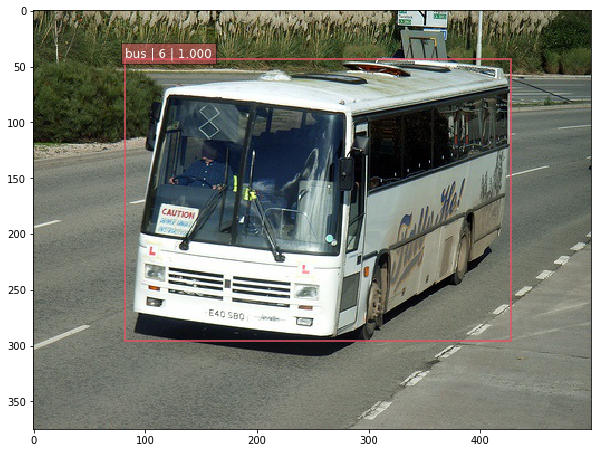

000542.jpg


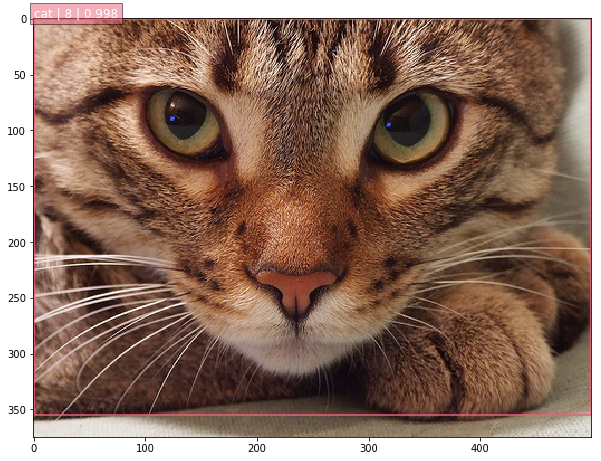

001150.jpg


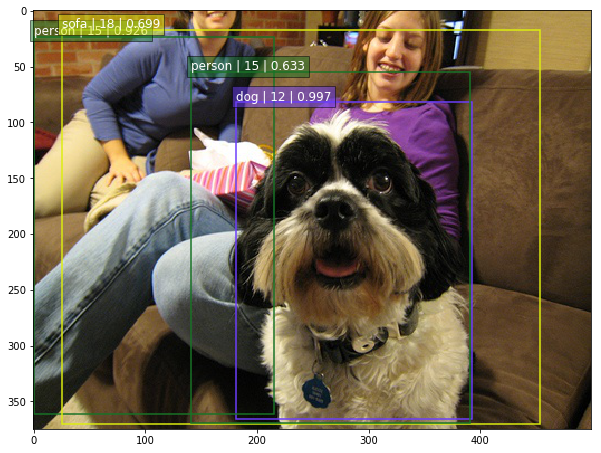

001763.jpg


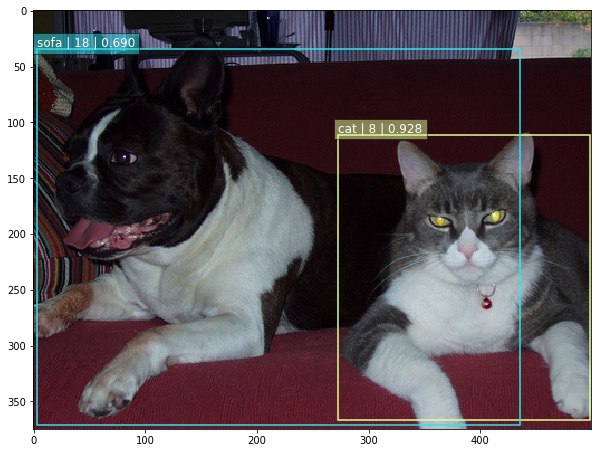

004545.jpg


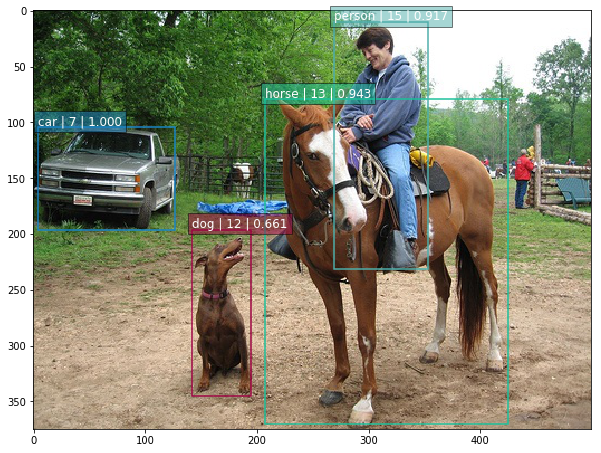

In [7]:
CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

# Test on some demo image and visualize output.
path = this_dir + '/data/images/'
output_path = this_dir + '/data/images_out/ssd_vgg/'
image_names = sorted(os.listdir(path))

############# Performance measurements block ###########
import time
from tqdm import tqdm
perf_image = this_dir + "/data/images/" + "000542.jpg"
times = list()
img = mpimg.imread(perf_image)
for i in tqdm(range(100)):
    timestart = time.time()
    isess.run([image_4d, predictions, localisations, bbox_img], feed_dict={img_input: img})
    times.append(time.time() - timestart)
print(times)    
performance = np.array(times)
print("Mean:", np.mean(performance))
print("Median:", np.median(performance))
print("Q25:", np.percentile(performance, 25))
print("Q75:", np.percentile(performance, 75))
##############################################################

########### Accuracy block ####################
import json
from tqdm import tqdm
ann_file = this_dir + '/data/annotations/instances_val2017.json'
test_images_path = this_dir + '/data/test_data/'
test_image_names = sorted(os.listdir(test_images_path))
cat_id_to_real_id = \
    {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16,
     18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 27: 25, 28: 26, 31: 27, 32: 28, 33: 29, 34: 30,
     35: 31, 36: 32, 37: 33, 38: 34, 39: 35, 40: 36, 41: 37, 42: 38, 43: 39, 44: 40, 46: 41, 47: 42, 48: 43, 49: 44,
     50: 45, 51: 46, 52: 47, 53: 48, 54: 49, 55: 50, 56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56, 62: 57, 63: 58,
     64: 59, 65: 60, 67: 61, 70: 62, 72: 63, 73: 64, 74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 81: 72,
     82: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 89: 79, 90: 80}
    
def parse_annotation(ann_file, img_dir, labels=[]):
    all_imgs = dict()
    seen_labels = set()
    with open(ann_file) as f:
        inst = json.load(f)
    boxes = {image['id']:dict() for image in inst['images']}
    cats = inst["categories"]
    for ann in inst['annotations']:
        obj = {}
        real_id = cat_id_to_real_id[ann['category_id']]
        namename = cats[real_id-1]["name"]
        seen_labels.add(namename)
        obj = []
        obj.append(int(round(ann['bbox'][1])))
        obj.append(int(round(ann['bbox'][0])))
        obj.append(int(round(ann['bbox'][1] + ann['bbox'][3])))        
        obj.append(int(round(ann['bbox'][0] + ann['bbox'][2])))
        if namename in boxes[ann["image_id"]]:
            boxes[ann['image_id']][namename].append(obj)
        else:
            boxes[ann['image_id']][namename] = [obj]
    for image in inst['images']:
        all_imgs[os.path.join(img_dir,image['file_name'])] =  boxes[image['id']]
    return all_imgs, seen_labels

imgs, labels = parse_annotation(ann_file, test_images_path)
        
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    if iou < 0:
        return 0
    # return the intersection over union value
    return iou

def compare_objdetect_accuracy(grrdict, predictdict):
    accs = []
    for key in grrdict:
        if key not in predictdict:
            accs += [0]* len(grrdict[key])
        else:
            for bbx in grrdict[key]:
                bbxaccs = []
                for bbox in predictdict[key]:
                    bbxaccs.append(bb_intersection_over_union(bbx, bbox))
                accs.append(max(bbxaccs))
            if len(grrdict[key]) < len(predictdict[key]):
                accs += [0]* (len(predictdict[key]) - len(grrdict[key]))
    for key in predictdict:
        if key not in grrdict:
            accs += [0]*len(predictdict[key])
    return np.mean(accs)

accuracys = []
for iname in tqdm(test_image_names):
    finame = test_images_path + iname
    print(iname)
    img = mpimg.imread(finame)
    rclasses, rscores, rbboxes = process_image(img)
    rbboxes[:,0] = rbboxes[:,0] * img.shape[0]
    rbboxes[:,1] = rbboxes[:,1] * img.shape[1]
    rbboxes[:,2] = rbboxes[:,2] * img.shape[0]
    rbboxes[:,3] = rbboxes[:,3] * img.shape[1]
    rbboxes = np.round(rbboxes).astype(int)
    #print(rbboxes)
    clss = [CLASSES[clsid] for clsid in rclasses]
    #print(clss)
    prdctns = dict()
    for i, cls in enumerate(clss):
        if cls in prdctns:
            prdctns[cls].append(rbboxes[i])
        else:
            prdctns[cls] = [rbboxes[i]]
    accuracys.append(compare_objdetect_accuracy(imgs[finame], prdctns))
print(accuracys)
print(np.mean(accuracys))
###############################################



for image_name in image_names:
    print(image_name)
    img = mpimg.imread(path + image_name)
    rclasses, rscores, rbboxes =  process_image(img)
    visualization.plt_bboxes(img, rclasses, rscores, rbboxes, output_path+image_name)

In [8]:
check = test_images_path + test_image_names[1]
img = mpimg.imread(check)
rclasses, rscores, rbboxes = process_image(img)
#rbboxes[:,0] = rbboxes[:,0] * img.shape[0]
# rbboxes[:,1] = rbboxes[:,1] * img.shape[1]
# rbboxes[:,2] = rbboxes[:,2] * img.shape[0]
# rbboxes[:,3] = rbboxes[:,3] * img.shape[1]
# rbboxes = np.round(rbboxes).astype(int)
#print(rbboxes)
print (rclasses, rscores, rbboxes)
prdctns = dict()
clss = [CLASSES[clsid] for clsid in rclasses]
for i, cls in enumerate(clss):
    if cls in prdctns:
        prdctns[cls].append(rbboxes[i])
    else:
        prdctns[cls] = [rbboxes[i]]
            
print(CLASSES[12])

[12] [ 0.63379776] [[ 0.10828683  0.00100785  1.          0.99310499]]
dog


In [9]:
imgs[check]

{'bear': [[69, 1, 633, 586]]}

In [10]:
compare_objdetect_accuracy(imgs[check], prdctns)

0.0

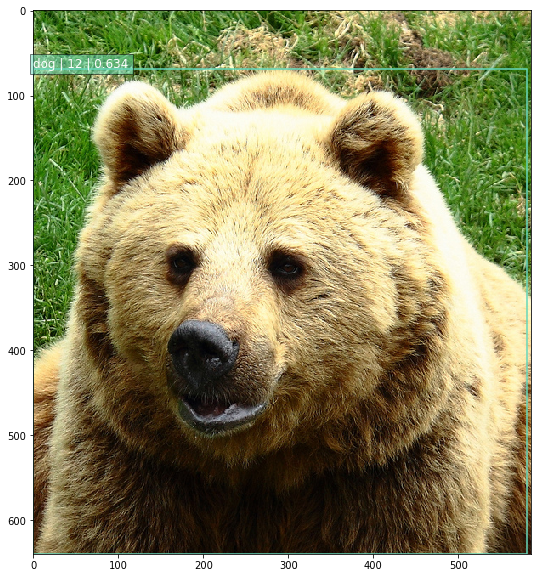

In [11]:
visualization.plt_bboxes(img, rclasses, rscores, rbboxes, output_path+"ololo")